In [1]:
from scipy import misc
from os import path
from glob import glob
import random
import numpy as np
import pandas as pd
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

## load data

In [3]:
%%time

# bag data from review test - no lights
imgs = np.array([misc.imread(f) for f in glob("../../../review/1/raw_imgs/*.png")])

## train data
train_img_folder = "../../data/camera_training/train/"
train_green = np.array([misc.imread(f) for f in glob(path.join(train_img_folder, "green/*"))])
train_red = np.array([misc.imread(f) for f in glob(path.join(train_img_folder, "red/*"))])
train_yellow = np.array([misc.imread(f) for f in glob(path.join(train_img_folder, "yellow/*"))])
train_nolight = np.array([misc.imread(f) for f in glob(path.join(train_img_folder, "nolight/*"))])

## test data
valid_img_folder = "../../data/camera_training/validation/"
valid_green = np.array([misc.imread(f) for f in glob(path.join(valid_img_folder, "green/*"))])
valid_red = np.array([misc.imread(f) for f in glob(path.join(valid_img_folder, "red/*"))])
valid_yellow = np.array([misc.imread(f) for f in glob(path.join(valid_img_folder, "yellow/*"))])
valid_nolight = np.array([misc.imread(f) for f in glob(path.join(valid_img_folder, "nolight/*"))])


# green = np.concatenate([train_green, valid_green], axis=0)
# red = np.concatenate([train_red, valid_red], axis=0)
# yellow = np.concatenate([train_yellow, valid_yellow], axis=0)
# nolight = np.concatenate([train_nolight, valid_nolight], axis=0)

CPU times: user 1min 43s, sys: 5.52 s, total: 1min 49s
Wall time: 2min 26s


### helper function

In [2]:


def explain(sess, model_graph, img, prob_thr=0.15):
    
    ## object detection

    image = model_graph.get_tensor_by_name("object_detection_api/image_tensor:0")
    boxes = model_graph.get_tensor_by_name("object_detection_api/detection_boxes:0")
    scores = model_graph.get_tensor_by_name("object_detection_api/detection_scores:0")
    classes = model_graph.get_tensor_by_name("object_detection_api/detection_classes:0")
    pred_boxes, pred_scores, pred_classes = sess.run([boxes, scores, classes],
                                                     feed_dict={image: np.expand_dims(img, axis=0)})
    
    pred_boxes = pred_boxes.squeeze()
    pred_scores = pred_scores.squeeze() # in descreding order
    pred_classes = pred_classes.squeeze()

    
    ## draw on image
    img = img.copy()
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    n = pred_boxes.shape[0]
#     topn = min(topn, n)
    h, w = img.shape[:2]
    for i in range(n):
        box = pred_boxes[i]
        score = pred_scores[i]
        if score < prob_thr: continue
#         if label != "traffic light": continue # traffic light
        if pred_classes[i] != 10: continue
        x0, y0 = box[1] * w, box[0] * h
        x1, y1 = box[3] * w, box[2] * h
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
        cv2.rectangle(img,(x0, y0),(x1, y1),(255,0,0),3)
        area = img[y0:y1, x0:x1]
        rpct = np.mean(area[:,:,0] == area[:,:,0].max())
        gpct = np.mean(area[:,:,1] == area[:,:,1].max())
        bpct = np.mean(area[:,:,2] == area[:,:,2].max())
        area_color = "r=%.2f, g=%.2f, b=%.2f" % (rpct, gpct, bpct)
        print(area_color)
        cv2.putText(img, "%s:%.2f" % ("tl", score), (x0+10, y0+20), font, 1.5 ,(0,0,255), 2, cv2.LINE_AA)
    return img

## model

In [30]:
import tensorflow as tf

class TLClassifier(object):
    def __init__(self, model_checkpoint):
        self.sess = None
        self.checkpoint = model_checkpoint
        self.prob_thr = 0.15
        self.TRAFFIC_LIGHT_CLASS = 10
        tf.reset_default_graph()
    
    def get_classification(self, img):
        if self.sess == None:
            gd = tf.GraphDef()
            gd.ParseFromString(tf.gfile.GFile(self.checkpoint, "rb").read())
            tf.import_graph_def(gd, name="object_detection_api")
            self.sess = tf.Session()
        
            g = tf.get_default_graph()
            self.image = g.get_tensor_by_name("object_detection_api/image_tensor:0")
            self.boxes = g.get_tensor_by_name("object_detection_api/detection_boxes:0")
            self.scores = g.get_tensor_by_name("object_detection_api/detection_scores:0")
            self.classes = g.get_tensor_by_name("object_detection_api/detection_classes:0")
        
        img_h, img_w = img.shape[:2]
        
        for h0 in [img_h//3]:
            for w0 in [0, img_w//3, img_w*2//3]:
                grid = img[h0:h0+img_h//3, w0:w0+img_w//3, :] # grid
        
                pred_boxes, pred_scores, pred_classes = self.sess.run([self.boxes, self.scores, self.classes],
                                                             feed_dict={self.image: np.expand_dims(grid, axis=0)})
                pred_boxes = pred_boxes.squeeze()
                pred_scores = pred_scores.squeeze() # in descreding order
                pred_classes = pred_classes.squeeze()

                traffic_light = None
                h, w = grid.shape[:2]
                for i in range(pred_boxes.shape[0]):
                    box = pred_boxes[i]
                    score = pred_scores[i]
                    if score < self.prob_thr: continue
                    if pred_classes[i] != self.TRAFFIC_LIGHT_CLASS: continue
                    x0, y0 = box[1] * w, box[0] * h
                    x1, y1 = box[3] * w, box[2] * h
                    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
                    area = np.abs((x1-x0) * (y1-y0)) / (w*h)
        #             print(area)
                    if area <= 0.001: continue
                    traffic_light = grid[y0:y1, x0:x1]
                    # take the first one - with the most confidence
                    if traffic_light is not None: break

                if traffic_light is None:
                    pass
                else:
                    brightness = cv2.cvtColor(traffic_light, cv2.COLOR_RGB2HSV)[:,:,-1] 
#                     brightness = cv2.cvtColor(traffic_light, cv2.COLOR_RGB2HSL)[:,:,-1] 
                    hs, ws = np.where(brightness >= (brightness.max()-30))
                    hs_mean = hs.mean()
                    tl_h = traffic_light.shape[0]
#                     print(hs_mean, tl_h)
                    if hs_mean / tl_h < 0.4:
                        return "red"
                    elif hs_mean / tl_h >= 0.55:
                        return "green"
                    else:
                        return "yellow"
#                     r = np.mean(traffic_light[:,:,0] == traffic_light[:,:,0].max())
#                     g = np.mean(traffic_light[:,:,1] == traffic_light[:,:,1].max())
#                     b = np.mean(traffic_light[:,:,2] == traffic_light[:,:,2].max())
#                     s = r + g + b
#                     r, g, b = r/s, g/s, b/s
#                     print(h0, w0)
#                     print(r, g, b)
#                     if r >= 0.70:
#                         return "red"
#                     elif b >= 0.25:
#                         return "green"
#                     else:
#                         return "yellow"
            return "nolight"

In [31]:
model = TLClassifier("./frozen_inference_graph.pb")

## test on different sets

In [32]:
%%time

img_preds = []
for img in imgs:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

nolight    1.0
dtype: float64
CPU times: user 6min 25s, sys: 51.6 s, total: 7min 17s
Wall time: 2min 12s


In [33]:
misclassified = imgs[np.where(np.array(img_preds)!="nolight")[0]]
print(misclassified.shape)
for i in range(misclassified.shape[0]):
    plt.figure()
    plt.imshow(misclassified[i])

(0, 600, 800, 3)


In [34]:
%%time

img_preds = []
for img in train_nolight:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

nolight    1.0
dtype: float64
CPU times: user 1min 44s, sys: 14.5 s, total: 1min 59s
Wall time: 35.2 s


In [35]:
%%time

img_preds = []
for img in valid_nolight:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds)  / len(img_preds))

nolight    1.0
dtype: float64
CPU times: user 45.1 s, sys: 6.31 s, total: 51.4 s
Wall time: 15.2 s


In [36]:
%%time

img_preds = []
for img in train_green:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds)  / len(img_preds))

green      0.974740
nolight    0.014116
yellow     0.011144
dtype: float64
CPU times: user 4min 40s, sys: 38.7 s, total: 5min 18s
Wall time: 1min 34s


(15, 1096, 1368, 3)


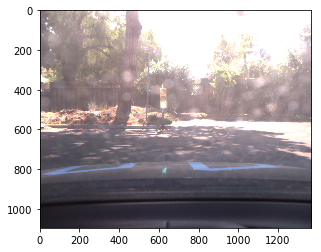

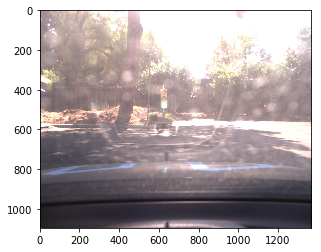

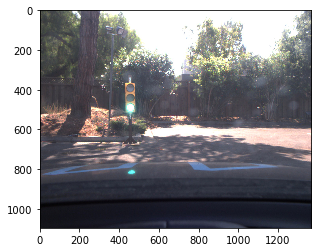

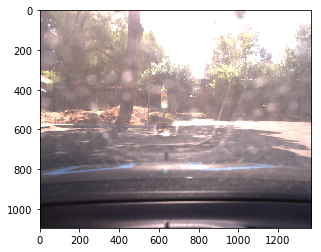

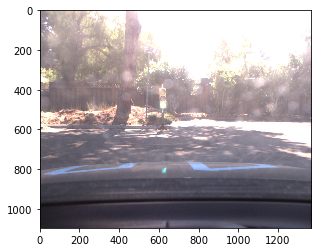

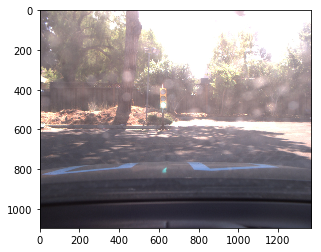

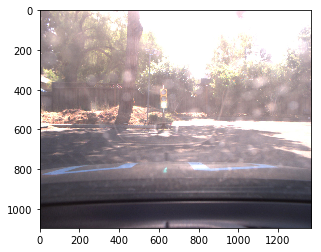

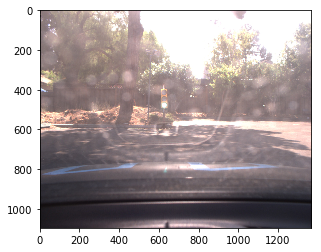

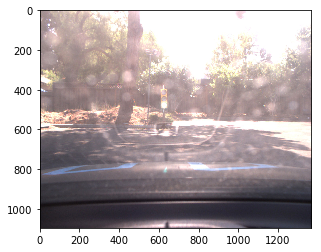

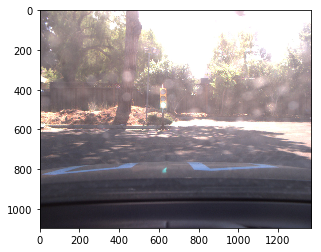

In [38]:
misclassified = train_green[np.where(np.array(img_preds)=="yellow")[0]]
print(misclassified.shape)
for i in range(min(10, misclassified.shape[0])):
    plt.figure()
    plt.imshow(misclassified[i])

In [39]:
%%time

img_preds = []
for img in train_red:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

red        0.960660
nolight    0.038071
yellow     0.001269
dtype: float64
CPU times: user 3min 10s, sys: 26 s, total: 3min 36s
Wall time: 1min 5s


(30, 1096, 1368, 3)


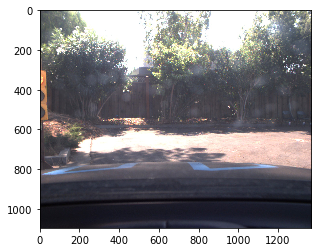

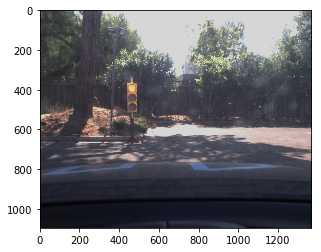

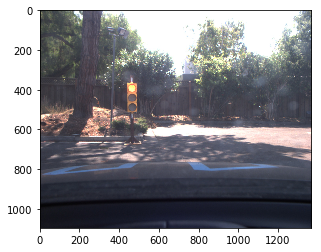

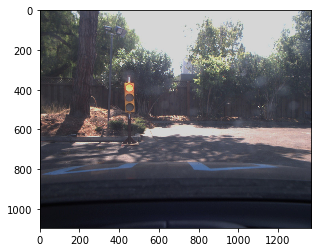

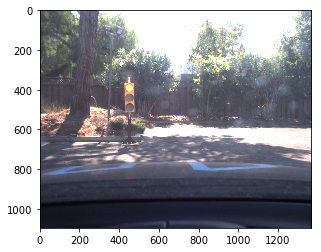

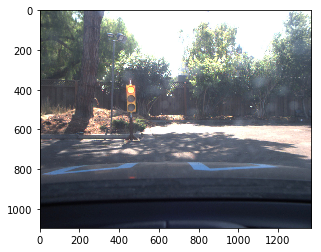

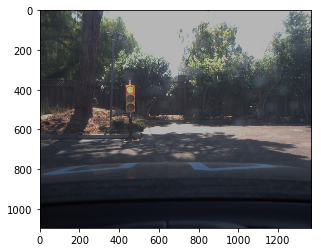

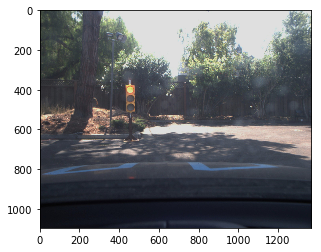

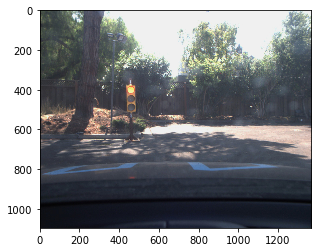

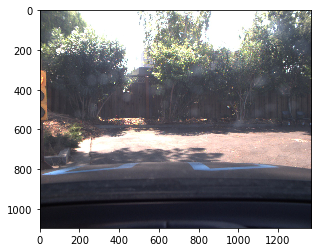

In [40]:
misclassified = train_red[np.where(np.array(img_preds)=="nolight")[0]]
print(misclassified.shape)
for i in range(min(10, misclassified.shape[0])):
    plt.figure()
    plt.imshow(misclassified[i])

In [41]:
%%time

img_preds = []
for img in train_yellow:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

yellow    0.966192
red       0.033808
dtype: float64
CPU times: user 2min 25s, sys: 19.8 s, total: 2min 45s
Wall time: 48.9 s


In [42]:
%%time

img_preds = []
for img in valid_red:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

red        0.95122
nolight    0.04878
dtype: float64
CPU times: user 1min 17s, sys: 10.8 s, total: 1min 28s
Wall time: 26.2 s


In [43]:
%%time

img_preds = []
for img in valid_green:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

green      0.986755
nolight    0.009934
yellow     0.003311
dtype: float64
CPU times: user 2min 6s, sys: 17 s, total: 2min 23s
Wall time: 42.5 s


In [44]:
%%time

img_preds = []
for img in valid_yellow:
    img_preds.append(model.get_classification(img))
print(pd.value_counts(img_preds) / len(img_preds))

yellow    0.96875
red       0.03125
dtype: float64
CPU times: user 57.3 s, sys: 7.58 s, total: 1min 4s
Wall time: 19.3 s
